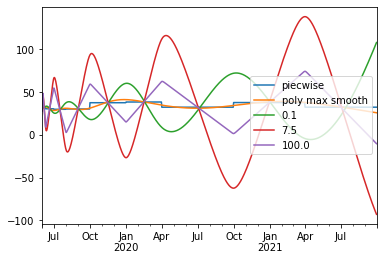

In [1]:
from curves import hyperbolic_tension_spline, bootstrap_contracts, max_smooth_interp
from curves import contract_period as cp
from datetime import date
import pandas as pd

contracts = [
    (date(2019, 5, 31), 34.875), 
    (date(2019, 6, 1), date(2019, 6, 2), 32.87),
    ((date(2019, 6, 3), date(2019, 6, 9)), 32.14),
    (pd.Period(year=2019, month=6, freq='M'), 31.08),
    (cp.month(2019, 7), 29.95),
    (cp.q_3(2019), 30.18),
    (cp.q_4(2019), 37.64),
    (cp.winter(2019), 38.05),
    (cp.summer(2020), 32.39),
    (cp.winter(2020), 37.84),
    (cp.gas_year(2020), 35.12)
]

pc_for_spline, bc_for_spline, _ = bootstrap_contracts(contracts, freq='D')
tensions = [0.1, 7.5, 100.0]

pc_for_spline.plot(legend=True)
max_smooth_curve, _ = max_smooth_interp(bc_for_spline, freq='D')
max_smooth_curve.plot(legend=True)

for tension in tensions:
    smooth_curve, _ = hyperbolic_tension_spline(bc_for_spline, freq='D', tension=tension, 
                                                        maximum_smoothness=True)
    ax = smooth_curve.plot(legend=True)

ax.legend(['piecwise', 'poly max smooth'] + tensions, loc='center right')

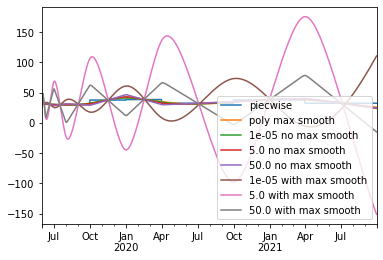

In [2]:


pc_for_spline, bc_for_spline, _ = bootstrap_contracts(contracts, freq='D')
tensions = [0.00001, 5.0, 50.0]

pc_for_spline.plot(legend=True)
max_smooth_curve, _ = max_smooth_interp(bc_for_spline, freq='D')
max_smooth_curve.plot(legend=True)

legend_items = [f'{t} no max smooth' for t in tensions] + [f'{t} with max smooth' for t in tensions]
for tension in tensions:
    smooth_curve, _ = hyperbolic_tension_spline(bc_for_spline, freq='D', tension=tension, 
                                                        maximum_smoothness=False)
    ax = smooth_curve.plot(legend=True)
for tension in tensions:
    smooth_curve, _ = hyperbolic_tension_spline(bc_for_spline, freq='D', tension=tension, 
                                                        maximum_smoothness=True)
    ax = smooth_curve.plot(legend=True)
    
    
ax.legend(['piecwise', 'poly max smooth'] + legend_items, loc='best')

In [61]:
from curves.hyperbolic_tension_spline import _populate_2h_matrix

def penalty_value_from_private(spline_params, tension):
    zs = spline_params['z'].values
    ys = spline_params['y'].values
    num_coeffs = len(spline_params)*2
    coeffs_array = np.zeros((num_coeffs))
    coeffs_array[::2] = zs
    coeffs_array[1::2] = ys
    num_sections = len(spline_params)-1
    tension_by_section = np.zeros((num_sections))
    h_is = np.zeros((num_sections))

    last_params = spline_params.iloc[0]
    for i in range(1, len(spline_params)):
        this_params = spline_params.iloc[i]
        h = this_params['t'] - last_params['t']
        effective_tension = tension / h
        tension_by_section[i-1] = effective_tension
        h_is[i-1] = h
        last_params = this_params

    tension_by_section_sqrd = tension_by_section*tension_by_section
    tau_h = tension_by_section * h_is
    tau_sqrd_hi = tau_h * tension_by_section
    matrix = np.zeros((num_coeffs, num_coeffs))
    _populate_2h_matrix(matrix, tension_by_section, tension_by_section_sqrd, tau_h, tau_sqrd_hi, h_is)
    penalty = np.matmul(np.matmul(coeffs_array.T, matrix), coeffs_array)/2
    return penalty


In [62]:
import numpy as np
def penalty_value(spline_params, tension):
    sum_penalty = 0.0
    last_params = spline_params.iloc[0]
    for i in range(1, len(spline_params)):
        this_params = spline_params.iloc[i]
        h = this_params['t'] - last_params['t']
        effective_tension = tension / h
        z_i = this_params['z']
        y_i = this_params['y']
        z_i_minus_1 = last_params['z']
        y_i_minus_1 = last_params['y']
        # coth (hyperbolic cotangent) = 1/tanh
        # csch (hyperbolic cosecant) = 1/sinh
        tau_h = tension
        sum_penalty += (effective_tension**4)*(y_i_minus_1-y_i)**2 - (z_i_minus_1 - z_i)**2 - tau_h*(\
          (z_i_minus_1**2 + z_i**2)/np.tanh(-tau_h) - 2.0*z_i_minus_1*z_i/np.sinh(-tau_h))/(effective_tension*effective_tension*h)
        
        last_params = this_params
    return sum_penalty


def penalty_value_2(spline_params, tension):
    sum_penalty = 0.0
    last_params = spline_params.iloc[0]
    for i in range(1, len(spline_params)):
        this_params = spline_params.iloc[i]
        h = this_params['t'] - last_params['t']
        effective_tension = tension / h
        z_i = this_params['z']
        y_i = this_params['y']
        z_i_minus_1 = last_params['z']
        y_i_minus_1 = last_params['y']
        # coth (hyperbolic cotangent) = 1/tanh
        # csch (hyperbolic cosecant) = 1/sinh
        tau_h = tension
        cosh_tau_h = np.cosh(tau_h)
        sinh_tau_h = np.sinh(tau_h)
        z_terms = cosh_tau_h / (effective_tension * sinh_tau_h) - 1.0/(effective_tension * effective_tension * h)
        tau_sqrd_over_h = effective_tension * effective_tension / h
        sum_penalty += z_i**2*z_terms + z_i_minus_1**2*z_terms + y_i**2*tau_sqrd_over_h + y_i_minus_1**2*tau_sqrd_over_h \
            + z_i*z_i_minus_1*2.0*(1.0/(effective_tension**2*h) - 1.0/(effective_tension*sinh_tau_h)) \
            - y_i*y_i_minus_1*2.0*tau_sqrd_over_h
        last_params = this_params
    return sum_penalty

intercept = 45.7
daily_slope = 0.8
num_curve_points = 5

daily_index = pd.period_range(start='2023-03-19', periods = num_curve_points, freq='D')
daily_prices = [intercept + daily_slope * i for i in range(num_curve_points)]
daily_curve = pd.Series(data=daily_prices, index=daily_index)

tensions = [0.01, 0.1, 0.5, 1.0, 10.0, 100.0]

for tension in tensions:
    hourly_curve_max_smooth, spline_params_max_smooth = hyperbolic_tension_spline(daily_curve, freq='H', tension=tension, 
                                                               maximum_smoothness=True)
    hourly_curve, spline_params = hyperbolic_tension_spline(daily_curve, freq='H', tension=tension, 
                                                               maximum_smoothness=False)
    print('max smooth')
    #print(penalty_value(spline_params_max_smooth, tension))
    max_smooth_penalty = penalty_value_2(spline_params_max_smooth, tension)
    max_smooth_penalty_private = penalty_value_from_private(spline_params_max_smooth, tension)
    print(max_smooth_penalty)
    print(max_smooth_penalty_private)
    print('no max smooth')
    #print(penalty_value(spline_params, tension))
    no_smooth_penalty = penalty_value_2(spline_params, tension)
    no_smooth_penalty_private = penalty_value_from_private(spline_params, tension)
    print(no_smooth_penalty)
    print(no_smooth_penalty_private)
    print('max smooth penalty improvement')
    print(no_smooth_penalty - max_smooth_penalty)
    
    print()
    #ax = hourly_curve.plot(legend=True)
    #print(spline_params)
    #print(tension*tension)
    

ax.legend(tensions)


#def smoothness_penalty(params):
    


max smooth
15807.017663855106
15807.017663860694
no max smooth
15695.990260854363
15695.99026086554
max smooth penalty improvement
-111.0274030007422

max smooth
2677524.78463459
2677524.7846348286
no max smooth
1569599.026087284
1569599.0260868073
max smooth penalty improvement
-1107925.758547306

max smooth
697824456.1936111
697824456.1936073
no max smooth
39239975.65219116
39239975.65218353
max smooth penalty improvement
-658584480.54142

max smooth
9283524237.34378
9283524237.343918
no max smooth
156959902.6087036
156959902.6087494
max smooth penalty improvement
-9126564334.735077

max smooth
3727756340844.0977
3727756340844.1016
no max smooth
15695990260.855469
15695990260.873047
max smooth penalty improvement
-3712060350583.242

max smooth
286801199520227.75
286801199520227.25
no max smooth
1569599026087.25
1569599026087.5
max smooth penalty improvement
-285231600494140.5



In [43]:
#print(spline_params.loc[spline_params.index[0]])

#penalty_value(spline_params, tension)

                         t          y         z
2023-03-19 00:00  0.000000  45.316667  0.000000
2023-03-20 00:00  0.002740  46.116667 -0.000003
2023-03-21 00:00  0.005479  46.916667  0.000003
2023-03-22 00:00  0.008219  47.716667 -0.000002
2023-03-23 00:00  0.010959  48.516667  0.000002
2023-03-23 23:00  0.013584  49.283333  0.000000
[ 0.00000000e+00  4.53166667e+01 -2.95108562e-06  4.61166667e+01
  2.58528669e-06  4.69166667e+01 -1.84663448e-06  4.77166667e+01
  1.88611196e-06  4.85166667e+01  0.00000000e+00  4.92833333e+01]
0.25


<AxesSubplot:>

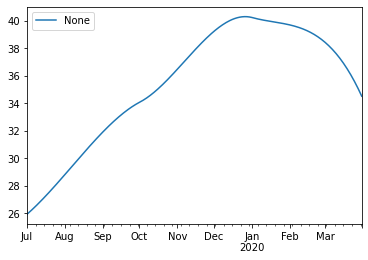

In [56]:
contracts = [
    (cp.q_3(2019), 30.18),
    (cp.q_4(2019), 37.64),
    (cp.q_1(2020), 38.64),
]
tension = 0.01
back_1st_deriv = None
spline_knots = [
    '2019-07-01',
#    '2019-08-18',
    '2019-10-01',
    '2019-10-02',
#    '2019-11-18',
    '2020-01-01',
    '2020-01-02',
#   '2020-02-01',
    '2020-03-30'
]
tension_curve_max_smooth, _ = hyperbolic_tension_spline(contracts, freq='D', tension=tension, maximum_smoothness=True,
                                                       back_1st_deriv=back_1st_deriv, spline_knots=spline_knots)
#tension_curve_no_max_smooth, _ = hyperbolic_tension_spline(contracts, freq='D', tension=tension, maximum_smoothness=False,
#                                                       back_1st_deriv=back_1st_deriv)
#old_max_smooth, _ = max_smooth_interp(contracts, freq='D', back_1st_deriv=back_1st_deriv)

tension_curve_max_smooth.plot(legend=True)
#ax = tension_curve_no_max_smooth.plot(legend=True)
#ax = old_max_smooth.plot(legend=True)

#ax.legend(['tension max smooth', 'tension no max smooth', 'old max smooth'])

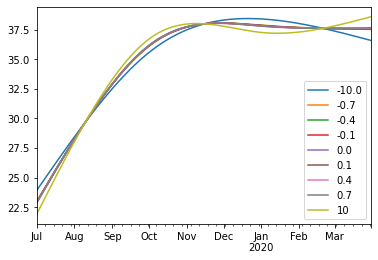

In [6]:
contracts = [
    (cp.q_3(2019), 30.18),
    (cp.q_4(2019), 37.64),
    (cp.q_1(2020), 37.64),
]
tension = 0.01
back_1st_derivs = [-10.0, -0.7, -0.4, -0.1, 0.0, 0.1, 0.4, 0.7, 10]
for back_1st_deriv in back_1st_derivs:
    tension_curve_no_max_smooth, _ = hyperbolic_tension_spline(contracts, freq='D', tension=tension, maximum_smoothness=False,
                                                       back_1st_deriv=back_1st_deriv)
    ax = tension_curve_no_max_smooth.plot(legend=True)

ax.legend(back_1st_derivs)